# 一、从零构建Transformer模型

In [1]:
# 导入相关库
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# 本项目需要使用torchtext，版本需要和pytorch匹配，由于torchtext已停止更新，最新版本为0.18，最高只能适配pytorch2.3
def check_torchtext():
    """
    本函数用于粗略检查pytorch和torchtext的版本是否匹配, 应该能满足大部分情况
    如自动安装torchtext时重新下载了pytorch, 请及时中断, 查询正确的匹配版本后手动安装
    """
    try:
        import torchtext
    except ImportError:
        version = torch.__version__
        print('pytorch版本为:', version)
        version = version.split('.')
        a = version[0]
        b = version[1]
        c = version[2][0]
        if int(a)==2:
            b = int(b)+15
            torchtext_version = f'0.{b}.{c}'
        if int(a)==1:
            b = int(b)+1
            torchtext_version = f'0.{b}.{c}'
        print('需要安装的torchtext版本为:', torchtext_version)
        ! pip install torchtext=={torchtext_version}

def check_device():
    if torch.cuda.is_available():
        print('GPU is available.')
        print('Number of GPU:', torch.cuda.device_count())
        print('GPU name:', torch.cuda.get_device_name(0))
    else:
        print('GPU is not available')
    
check_torchtext()
check_device()

GPU is available.
Number of GPU: 1
GPU name: NVIDIA GeForce RTX 3090


## （一）位置编码

torch.Size([32, 50, 512])


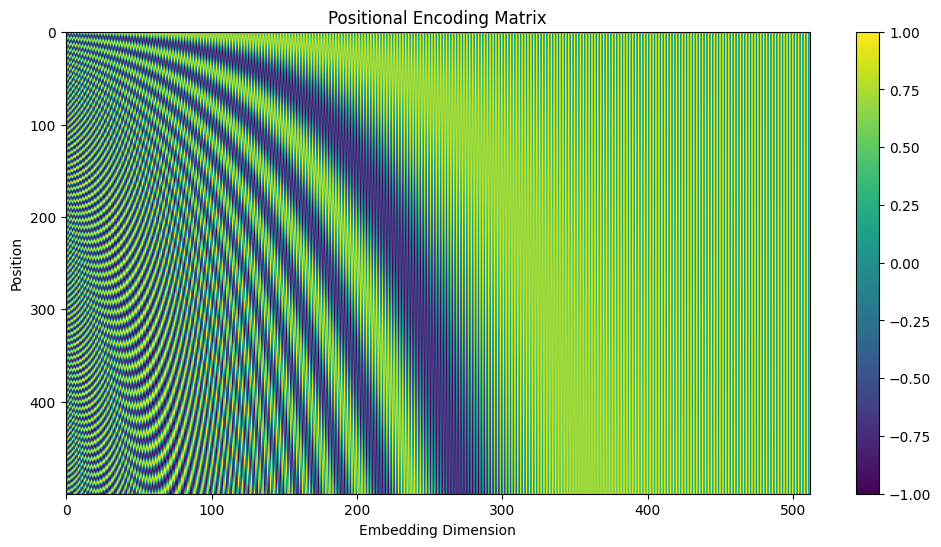

In [2]:
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        """
        为序列加入位置编码
        Args:
            d_model: 序列矩阵的embedding的维度
            max_len: 位置编码矩阵的最大序列长度, 这个长度可以比实际序列长度长, 相加时只要截取实际序列的长度即可
        """
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        
        pe = torch.zeros(max_len, d_model)  # 创建一个(max_len, d_model)的全零矩阵, 用于保存位置编码值
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # 创建一个(max_len, 1)的矩阵, 表示位置索引
        
        # 创建一个(d_model/2,)的矩阵, 用于储存每个维度的频率因子(每两列的频率因子是相同的, 因此一共有d_model/2个频率因子)
        # torch.arange(0, d_model, 2).float()相当于生成位置编码公式中的索引i
        # 使用log和exp分开计算能够确保在数值范围内进行线性缩放, 从而避免浮点数溢出或精度丢失
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # 计算位置编码
        # 对于维度的偶数列
        pe[:, 0::2] = torch.sin(position * div_term)  # 由广播机制：(max_len, 1)*(d_model/2,)->(max_len, d_model/2)
        # 对于维度的奇数列
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # 增加一个batch维度, 使其能够与输入张量相加
        pe = pe.unsqueeze(0)  # (max_len, d_model)->(1, max_len, d_model)
        # 将位置编码矩阵注册为模型的缓冲区, 这样它将不会被认为是模型的参数
        # 缓冲区会随着模型一起保存和加载
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        # 原文3.4节中提到, 为了使得单词嵌入表示相对大一些, 乘sqrt(d_model), 以确保嵌入向量的值不会被位置编码淹没。
        x = x * math.sqrt(self.d_model)
        
        # 将位置编码添加到输入张量上
        # 位置编码依据max_len生成, 而输入序列长度的seq_len应小于等于max_len
        # 通常会将输入序列补全或截断到统一长度, 让这个长度等于max_len即可
        x = x + self.pe[:, :x.size(1), :]
        return x


# 可视化
d_model = 512  # 例如，模型的维度
pe = PositionalEncoding(d_model)

# 创建一个随机张量，形状为 (batch_size, seq_len, d_model)
x = torch.randn(32, 50, d_model)

# 添加位置编码
x = pe(x)
print(x.shape)  # 应该输出 torch.Size([32, 50, 512])

# 获取位置编码矩阵
pe_matrix = pe.pe[0]

# 绘制位置编码矩阵
plt.figure(figsize=(12, 6))
plt.imshow(pe_matrix.detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Positional Encoding Matrix')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.show()

## （二）多头注意力

torch.Size([32, 10, 512])
torch.Size([32, 8, 10, 10])


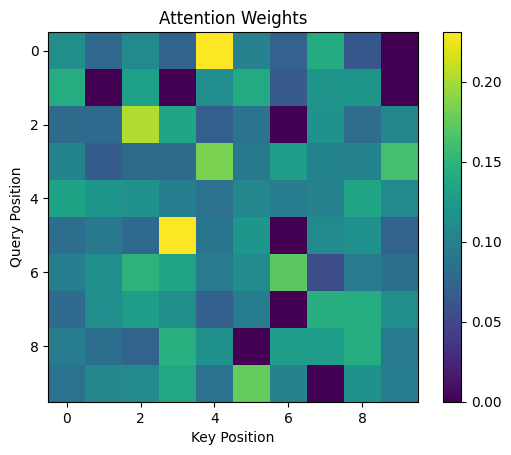

In [3]:
# 多头自注意力
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"  # 确保num_heads能整除d_model
        
        self.d_model = d_model
        self.d_k = d_model // num_heads  # 这里简单起见，我们只考虑 d_v = d_k = d_q = d_model / num_heads，因此只定义d_k
        self.h = num_heads

        # 这里定义的 linear 参数是 (d_model, d_model)
        self.q_linear = nn.Linear(d_model, d_model)  # W_Q
        self.k_linear = nn.Linear(d_model, d_model)  # W_K
        self.v_linear = nn.Linear(d_model, d_model)  # W_V
        self.o_linear = nn.Linear(d_model, d_model)  # W_O
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, q, k, v, mask=None):
        """
        input:
            q, k, v: (batch_size, seq_len, d_model)
                对于自注意力, 如果输入序列为 x, 那么 q=x, k=x, v=x
                对于交叉注意力, 如果序列 x_1 对序列 x_2 做 query, 则 q=x_1, k=x_2, v=x_2
            mask: (batch_size, 1, 1, seq_len)或(batch_size, 1, seq_len, seq_len)
                mask有多种形式, 可以使用0、1来mask, 也可以使用True、False来mask, 根据具体代码执行mask
        output:
            seq: (batch_size, seq_len, d_model)
            attention: (batch_size, h, len_q, len_k) 每个头均有一个注意力权重矩阵
                对于自注意力, len_q = len_k = len_v = seq_len
                对于交叉注意力, len_q = tgt_seq_len , len_k = len_v = src_seq_len
        """
        batch_size = q.size(0)
        
        # 将原始序列变换为QKV矩阵
        # 以 q 的变换为例。序列 q=x 经过 q_linear 变换后，形状仍然为(batch_size, seq_len, d_model)
        # 使用.view方法用于改变张量形状。这里变换成了(batch_size, seq_len, num_heads, d_k)，即把 d_model 拆成了 num_heads*d_k
        # 使用.transpose方法，将形状进一步变为(batch_size, num_heads, seq_len, d_k)
        q = self.q_linear(q).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)  # (batch_size, seq_len, d_model)->(batch_size, num_heads, seq_len, d_k)
        k = self.k_linear(k).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        
        # 每个头并行计算相似度得分，相似度矩阵形状为(batch_size, num_heads, len_q, len_k)
        # 即每个头都形成了(len_q, len_k)的 scores，scores 的第一行，意思是第一个位置的 q 对所有位置的 k 的得分，因此后续的 softmax 是按 scores 的行来做的
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            # 这里我们假设mask中为0的地方是需要遮蔽的地方
            scores = scores.masked_fill(mask == 0, -1e9)  # 通过把掩码的位置设置为一个较大的负数，让掩码位置的softmax趋近于零
        
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)  # 得到所有batch的每个头的相似度矩阵
        
        # 相似度矩阵与v相乘得到输出
        output = torch.matmul(attention, v)  # (batch_size, num_heads, seq_len, d_k)
        
        # 首先将output变为(batch_size, seq_len, num_heads, d_k)
        # .contiguous用于确保张量在内存中是连续的
        # 将张量形状变为(batch_size, seq_len, d_model)，相当于把所有头的结果拼接了起来，即 d_k*num_heads 拼成了 d_model
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.o_linear(output)  # 使用w_o进行线性变换
        
        # 最终传出输出和每个头的attention，attention根据需要可用于后续的可视化
        return output, attention


# 示例用法
mha = MultiHeadAttention(d_model=512, num_heads=8)

x = torch.randn(32, 10, d_model)  # 长度为10的序列矩阵

output, attention = mha(x, x, x)

print(output.shape)
print(attention.shape)

# 可视化第0个batch的第0个头的attention
head_attention = attention[0, 0].detach().numpy()  # 提取第 0 个 batch 的第 0 个头

# 绘制热力图
plt.imshow(head_attention, cmap='viridis')
plt.colorbar()
plt.title('Attention Weights')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.show()

## （三）前馈神经网络和层归一化

In [4]:
# 前馈神经网络
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        # d_ff 默认设置为 2048，更多的中间层节点数可以增加网络的容量，使其能够学习更复杂的函数映射。
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        """
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

# 层归一化, 也可以使用PyTorch内置的层归一化nn.LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        # LayerNorm是对d_model而言的
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a * (x - mean) / (std + self.eps) + self.b

## （四）编码器层和编码器

In [5]:
# 编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        """
        每个EncoderLayer包括两个子层: 多头注意力层和前馈神经网络层。每个子层都使用了残差连接和层归一化。
        """
        super().__init__()
        self.norm_1 = LayerNorm(d_model)
        self.norm_2 = LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ff = FeedForward(d_model, d_ff=d_ff, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        """
        原文中使用: LayerNorm(x + SubLayer(x))
        也有部分实现使用: x + SubLayer(LayerNorm(x))
        这里我们使用原文的实现
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        output, _ = self.attn(x, x, x, mask=src_mask)
        x = self.norm_1(x + self.dropout_1(output))  # 多头自注意力子层
        x = self.norm_2(x + self.dropout_2(self.ff(x)))  # 前馈神经网络子层
        return x

# 编码器
class Encoder(nn.Module):
    """
    编码器由多个编码器层堆叠而成。
    """
    def __init__(self, num_layers, d_model, num_heads, d_ff=2048, dropout=0.1):
        """
        在原始论文的图 1 和描述中, 作者提到每个子层(Multi-Head Attention 和 Feed-Forward Network)之后会进行 Layer Normalization。
        但是，论文并没有明确提到在整个编码器或解码器之后进行额外的 Layer Normalization。
        许多后续的实现，通常会在编码器和解码器的堆叠之后再进行一次 Layer Normalization。
        """
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, src_mask=None):
        """
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        for layer in self.layers:
            x = layer(x, src_mask)
        return self.norm(x)

## （五）解码器层和解码器

In [6]:
# 解码器层
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        """
        每个DecoderLayer包括三个子层: 自注意力层、编码器-解码器注意力层和前馈神经网络层。每个子层都使用了残差连接和层归一化。
        """
        super().__init__()
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        self.norm_3 = nn.LayerNorm(d_model)
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ff = FeedForward(d_model, d_ff=d_ff, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

    def forward(self, x, enc_output, memory_mask=None, tgt_mask=None):
        """
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        output_1, _ = self.self_attn(x, x, x, mask=tgt_mask)
        x = self.norm_1(x + self.dropout_1(output_1))  # 第一个子层：多头自注意力层
        
        output_2, _ = self.enc_dec_attn(x, enc_output, enc_output, mask=memory_mask)  # k, v来自编码器输出
        x = self.norm_2(x + self.dropout_2(output_2))  # 第二个子层：编码器-解码器注意力层
        
        x = self.norm_3(x + self.dropout_3(self.ff(x)))  # 第三个子层：前馈神经网络层
        return x

# 解码器
class Decoder(nn.Module):
    """
    解码器由多个解码器层堆叠而成。
    """
    def __init__(self, num_layers, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, enc_output, memory_mask=None, tgt_mask=None):
        """
        input: (batch_size, seq_len, d_model)
        output: (batch_size, seq_len, d_model)
        """
        for layer in self.layers:
            x = layer(x, enc_output, memory_mask, tgt_mask)
        return self.norm(x)

## （六）Transformer模型

In [7]:
# 完整Transformer模型
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_layers=6, num_heads=8, d_ff=2048, dropout=0.1, max_len=500):
        super().__init__()
        # src_vocab_size和tgt_vocab_size分别是源序列和目标序列的词典大小
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)  # 定义嵌入层，用于将序列转换为维度为d_model的嵌入向量
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)  # 位置编码层

        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, dropout)

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        """
        src和tgt为token_id
        src: (batch_size, src_seq_len)
        tgt: (batch_size, tgt_seq_len)
        在 Transformer 模型中, 输入序列通常已经经过填充(padding)处理。
        填充是为了使所有输入序列的长度一致，从而可以将它们放入一个批次中进行处理。
        """
        src = self.dropout(self.positional_encoding(self.src_embedding(src)))  # 位置编码后使用了dropout，原文在Regularization中有提到
        tgt = self.dropout(self.positional_encoding(self.tgt_embedding(tgt)))

        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, memory_mask, tgt_mask)
        
        # 在训练过程中，logits 通常会通过 CrossEntropyLoss 来计算损失，而 CrossEntropyLoss 会在内部应用 softmax
        # 因此这里可以不用softmax，在推理阶段，可以在output后手动加入softmax
        output = self.fc_out(dec_output)
        return output

## （七）构造掩码

In [8]:
# 填充掩码
def make_padding_mask(seq, pad_id, return_int=True, true_to_mask=False):
    """
    构造padding mask, 参数设置根据不同的Transformer实现来确定
    Args:
        seq: 需要构造mask的序列(batch, seq_len), 该序列使还未进行Embedding, 里面放的是token_id
        pad_id: 用于填充的特殊字符<PAD>所对应的token_id, 根据不同代码设置
        return_int: 是否返回int形式的mask, 默认为True
        true_to_mask: 默认为False, 对于bool mask: True代表在True的位置遮蔽, False代表在False的位置遮蔽。对于int mask: True代表在1的位置遮蔽, False代表在0的位置遮蔽
    
    Returns:
        mask: (batch, seq_len), 不同的Transformer实现需输入的形状也不同, 根据需要进行后续更改
    """
    mask = (seq == pad_id)  # (batch, seq_len), 在<PAD>的位置上生成True, 真实序列的位置为False

    if true_to_mask is False:
        mask = ~mask
    
    if return_int:
        mask = mask.int()
    
    return mask

# 因果掩码
def make_sequence_mask(seq, return_int=True, true_to_mask=False):
    """
    构造sequence mask, 参数设置根据不同的Transformer实现来确定
    Args:
        seq: 需要构造mask的序列(batch, seq_len), 该序列使还未进行Embedding, 里面放的是token_id
        return_int: 是否返回int形式的mask, 默认为True
        true_to_mask: 默认为False, 对于bool mask: True代表在True的位置遮蔽, False代表在False的位置遮蔽。对于int mask: True代表在1的位置遮蔽, False代表在0的位置遮蔽
    
    Returns:
        mask: (seq_len, seq_len), 不同的Transformer实现需输入的形状也不同, 根据需要进行后续更改
    """
    _, seq_len = seq.shape
    mask = torch.tril(torch.ones(seq_len, seq_len))  # (seq_len, seq_len), 下三角为1, 上三角为0
    mask = 1 - mask
    mask = mask.bool()

    if true_to_mask is False:
        mask = ~mask
    
    if return_int:
        mask = mask.int()
    
    return mask


# 示例
seq = torch.tensor([[1,1,1,1,1,1,1,1,1,1,1,0], [1,1,1,1,1,1,1,1,1,1,0,0]])  # (batch_size, src_seq_len=12)

# 比较四种不同的padding_mask
print(make_padding_mask(seq=seq, pad_id=0, return_int=True, true_to_mask=False))
print(make_padding_mask(seq=seq, pad_id=0, return_int=True, true_to_mask=True))
print(make_padding_mask(seq=seq, pad_id=0, return_int=False, true_to_mask=False))
print(make_padding_mask(seq=seq, pad_id=0, return_int=False, true_to_mask=True))

# 展示sequence_mask
print(make_sequence_mask(seq=seq, return_int=True, true_to_mask=False))

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]], dtype=torch.int32)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=torch.int32)
tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False, False]])
tensor([[False, False, False, False, False, False, False, False, False, False,
         False,  True],
        [False, False, False, False, False, False, False, False, False, False,
          True,  True]])
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0

In [9]:
# 进一步分别构造src_mask、memory_mask、tgt_mask
def make_src_mask(src, pad_id, return_int=True, true_to_mask=False):
    """构造src_mask

    Args:
        src: 源序列(batch_size, src_len)
        pad_id: 补全符号的token_id
        return_int: 是否返回int形式的mask, 默认为True
        true_to_mask: 默认为False, 对于bool mask: True代表在True的位置遮蔽, False代表在False的位置遮蔽。对于int mask: True代表在1的位置遮蔽, False代表在0的位置遮蔽

    Returns:
        src_mask: (batch_size, 1, 1, src_len)
    """
    padding_mask = make_padding_mask(src, pad_id, return_int=return_int, true_to_mask=true_to_mask)
    padding_mask = padding_mask.unsqueeze(1)
    padding_mask = padding_mask.unsqueeze(2)
    return padding_mask

def make_memory_mask(src, pad_id, return_int=True, true_to_mask=False):
    """构造memory_mask

    Args:
        src: 源序列(batch_size, src_len)
        pad_id: 补全符号的token_id
        return_int: 是否返回int形式的mask, 默认为True
        true_to_mask: 默认为False, 对于bool mask: True代表在True的位置遮蔽, False代表在False的位置遮蔽。对于int mask: True代表在1的位置遮蔽, False代表在0的位置遮蔽

    Returns:
        memory_mask: (batch_size, 1, 1, src_len)
    """
    padding_mask = make_padding_mask(src, pad_id, return_int=return_int, true_to_mask=true_to_mask)
    padding_mask = padding_mask.unsqueeze(1)
    padding_mask = padding_mask.unsqueeze(2)
    return padding_mask

def make_tgt_mask(tgt, pad_id, return_int=True, true_to_mask=False):
    """构造tgt_mask

    Args:
        tgt: 目标序列(batch_size, tgt_len)
        pad_id: 补全符号的token_id
        return_int: 是否返回int形式的mask, 默认为True
        true_to_mask: 默认为False, 对于bool mask: True代表在True的位置遮蔽, False代表在False的位置遮蔽。对于int mask: True代表在1的位置遮蔽, False代表在0的位置遮蔽

    Returns:
        tgt_mask: (batch_size, 1, tgt_len, tgt_len)
    """
    padding_mask = make_padding_mask(tgt, pad_id, return_int=return_int, true_to_mask=true_to_mask)  # (batch_size, tgt_len)
    padding_mask = padding_mask.unsqueeze(1)
    padding_mask = padding_mask.unsqueeze(2)  # (batch_size, 1, 1, tgt_len)
    padding_mask = padding_mask.repeat(1, 1, tgt.size(1), 1)  # (batch_size, 1, tgt_len, tgt_len)

    sequence_mask = make_sequence_mask(tgt, return_int=True, true_to_mask=False)  # (tgt_len, tgt_len)
    sequence_mask = sequence_mask.unsqueeze(0)
    sequence_mask = sequence_mask.unsqueeze(1)  # (1, 1, tgt_len, tgt_len)
    sequence_mask = sequence_mask.repeat(tgt.size(0), 1, 1, 1)  # (batch_size, 1, tgt_len, tgt_len)

    # 合并两个mask
    if true_to_mask is False:  # 根据不同类型的mask, 使用"与"或"或"的方式进行合并
        mask = padding_mask & sequence_mask
    else:
        mask = padding_mask | sequence_mask
    return mask



# 示例
src = torch.tensor([[1,1,1,1,1,1,1,1,1,0,0,0],
                    [1,1,1,1,1,1,1,0,0,0,0,0]])
tgt = torch.tensor([[1,1,1,1,1,1,1,0,0,0,0],
                    [1,1,1,1,1,0,0,0,0,0,0]])

src_mask = make_src_mask(src, pad_id=0)
print('src_mask:')
print(src_mask)
print(src_mask.shape)

memory_mask = make_memory_mask(src, pad_id=0)  # memory_mask和src_mask这里是一样的, 但在transformer内部会广播成不同的维度
print('memory_mask:')
print(memory_mask)
print(memory_mask.shape)

tgt_mask = make_tgt_mask(tgt, pad_id=0)
print('tgt_mask:')
print(tgt_mask)
print(tgt_mask.shape)

src_mask:
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]],


        [[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]]], dtype=torch.int32)
torch.Size([2, 1, 1, 12])
memory_mask:
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]],


        [[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]]], dtype=torch.int32)
torch.Size([2, 1, 1, 12])
tgt_mask:
tensor([[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]],


        [[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0,

# 二、使用从零构建的Transformer模型完成中英翻译demo

In [10]:
from torchtext.data.metrics import bleu_score  # torchtext已停止更新，不影响使用，torchtext0.18版本对应PyTorch2.3版本，更高的pytorch版本导入torchtext将报错
import json
import opencc  # 使用的数据集是繁体字，用该库转换为简体字

from torchtext.data.utils import get_tokenizer  # 用于英文分词
import jieba  # 用于中文分词
from tqdm import tqdm
from collections import Counter  #  用于统计词频 
import os

## （一）读取并构造数据集

In [11]:
# 创建 OpenCC 转换器实例
converter = opencc.OpenCC('t2s')  # 't2s'表示从繁体到简体

# 将该数据集保存为json格式
dataset = []
with open('./data/cmn-eng/cmn.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        line = line.split('\t')
        en = line[0]
        cn = line[1]
        cn = converter.convert(cn)
        dataset.append({'english': en, 'chinese': cn})

# 将每个字典逐行写入 JSON 文件
with open('./data/cmn-eng/dataset.json', 'w', encoding='utf-8') as json_file:
    for item in dataset:
        json.dump(item, json_file, ensure_ascii=False)
        json_file.write('\n')

## （二）分词并构建词典

In [12]:
# 英文分词示例
en_tokenizer = get_tokenizer('basic_english')
text = "Hello! How are you doing today?"
tokens = en_tokenizer(text)
print(tokens)

# 词语级分词【构造的词典很大，训练可能较慢】
# def cn_tokenizer(text):
#     return jieba.lcut(text)
# 字符级分词【构造的词典较小，但可能导致语义不连贯】
def cn_tokenizer(text):
    return list(text)

text = "你好！你今天好吗？"
tokens = cn_tokenizer(text)
print(tokens)

# ----------------------------------------------------------------
# 读取dataset
dataset = []
with open('./data/cmn-eng/dataset.json', 'r', encoding='utf-8') as f:
    for line in f:
        dataset.append(json.loads(line))

# ----------------------------------------------------------------       
# 构建词典
en_max_len = 0
cn_max_len = 0
en_vocab = []
cn_vocab = []
for data in tqdm(dataset, desc='Building Vocabulary'):
    en_text = data['english']
    cn_text = data['chinese']

    en_tokens = en_tokenizer(en_text)
    cn_tokens = cn_tokenizer(cn_text)
    en_max_len = max(en_max_len, len(en_tokens))
    cn_max_len = max(cn_max_len, len(cn_tokens))

    en_vocab.extend(en_tokens)
    cn_vocab.extend(cn_tokens)

en_counter = dict(Counter(en_vocab))
cn_counter = dict(Counter(cn_vocab))

# 保存词频统计
with open('./data/cmn-eng/en_counter.json', 'w', encoding='utf-8') as f:
    json.dump(en_counter, f, ensure_ascii=False, indent=4)
with open('./data/cmn-eng/cn_counter.json', 'w', encoding='utf-8') as f:
    json.dump(cn_counter, f, ensure_ascii=False, indent=4)

# 为简单起见，将数据集所有的token都添加到词典中，不考虑词频和未知token
# 定义特殊字符
start_token = '<sos>'
end_token = '<eos>'
pad_token = '<pad>'

special_tokens = [start_token, end_token, pad_token]
en_vocab = special_tokens + list(en_counter.keys())
cn_vocab = special_tokens + list(cn_counter.keys())

# 构建词典
en_dict_token2id = {token: i for i, token in enumerate(en_vocab)}
en_dict_id2token = {i: token for i, token in enumerate(en_vocab)}
cn_dict_token2id = {token: i for i, token in enumerate(cn_vocab)}
cn_dict_id2token = {i: token for i, token in enumerate(cn_vocab)}

# 分别保存token到token_id和token_id到token的词典
with open('./data/cmn-eng/en_dict_token2id.json', 'w') as f:
    json.dump(en_dict_token2id, f, ensure_ascii=False, indent=4)
with open('./data/cmn-eng/cn_dict_token2id.json', 'w') as f:
    json.dump(cn_dict_token2id, f, ensure_ascii=False, indent=4)
with open('./data/cmn-eng/en_dict_id2token.json', 'w') as f:
    json.dump(en_dict_id2token, f, ensure_ascii=False, indent=4)
with open('./data/cmn-eng/cn_dict_id2token.json', 'w') as f:
    json.dump(cn_dict_id2token, f, ensure_ascii=False, indent=4)

# 计算词典大小
en_vocab_size = len(en_vocab)
cn_vocab_size = len(cn_vocab)
print(f'英文字典大小为：{en_vocab_size}')
print(f'英文最长序列长度为：{en_max_len}')
print(f'中文字典大小为：{cn_vocab_size}')
print(f'中文最长序列长度为：{cn_max_len}')

['hello', '!', 'how', 'are', 'you', 'doing', 'today', '?']
['你', '好', '！', '你', '今', '天', '好', '吗', '？']


Building Vocabulary: 100%|██████████| 29909/29909 [00:00<00:00, 60242.68it/s]


英文字典大小为：7192
英文最长序列长度为：38
中文字典大小为：2839
中文最长序列长度为：44


## （三）token与token_id的转换

In [13]:
# 由token转换为token_id
def text2id(text, language, dict=None, dict_path='./data/cmn-eng', en_max_len=45, cn_max_len=50):
    """将一段文本转换为该词典下对应的token_id, 并根据max_len补全pad, 这里将中文填充为50, 英文填充为45

    Args:
        text : 输入文本
        language : 语言, 中文或英文
        dict : 词典, 如果为None, 则从dict_path中加载词典
        dict_path : 词典路径

    Returns:
        list : 列表, 里面是每个token的token_id
    """
    if language == 'cn':
        token = cn_tokenizer(text)
        max_len = cn_max_len
    if language == 'en':
        token = en_tokenizer(text)
        max_len = en_max_len
    if dict is None:
        with open(f'{dict_path}/{language}_dict_token2id.json', 'r') as f:
            dict = json.load(f)
    
    token_id = [dict[t] for t in token]
    token_id = [dict['<sos>']] + token_id + [dict['<eos>']]
    if len(token_id) < max_len:
        token_id += [dict['<pad>']] * (max_len - len(token_id))
    return token_id

# 由token_id转换为token
def id2text(token_id, language, dict=None, dict_path='./data/cmn-eng'):
    """将一个列表中的token_id转换为对应的文本, 并去掉<sos>、<eos>、<pad>

    Args:
        token_id : 装有token_id的列表
        language : 语言, 中文或英文
        dict : 词典, 如果为None, 则从dict_path中加载词典
        dict_path : 词典路径

    Returns:
        str : 文本
    """
    if dict is None:
        with open(f'{dict_path}/{language}_dict_id2token.json', 'r') as f:
            dict = json.load(f)
            dict = {int(k): v for k, v in dict.items()}  # 词典保存为json后，键会变成字符串, 转换为int

    token = [dict[i] for i in token_id if i not in [0, 1, 2]]
    if language == 'cn':
        return ''.join(token)
    if language == 'en':
        text = ''
        CAP = False  # 调整是否大写
        # 调整英文单词、符号之间空格的有无
        for i, t in enumerate(token):
            if i == 0:
                text += t.capitalize()  # 首字母大写
            else:
                if t in ",.!?;:)}]'\"":
                    text += t
                    if t in ".?!":
                        CAP = True
                else:
                    if CAP:
                        t = t.capitalize()
                        CAP = False
                    text += ' ' + t
        return text

# 示例，由于未加入unk，必须使用词典里有的单词
# 中文token转token_id
cn_text = '你好吗？我很好！谢谢，不客气。'
cn_token_id = text2id(cn_text, 'cn', cn_dict_token2id)
print(cn_token_id)  # <sos>、<eos>、<pad>的token_id分别为0、1、2
print('length:', len(cn_token_id))
# 英文token转token_id
en_text = 'How are you? I am fine! Thank you, you are welcome.'
en_token_id = text2id(en_text, 'en', en_dict_token2id)
print(en_token_id)
print('length:', len(en_token_id))

# 中文token_id转token
print(id2text(cn_token_id, 'cn', cn_dict_id2token))
# 英文token_id转token
print(id2text(en_token_id, 'en', en_dict_id2token))

[0, 5, 6, 34, 32, 18, 96, 6, 12, 53, 53, 130, 22, 701, 72, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
length: 50
[0, 101, 235, 74, 19, 11, 136, 113, 7, 214, 74, 249, 74, 235, 81, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
length: 45
你好吗？我很好！谢谢，不客气。
How are you? I am fine! Thank you, you are welcome.


## （四）构建DataLoader

In [14]:
from torch.utils.data import random_split, DataLoader, Dataset
import numpy as np

class TranslateDataset(Dataset):
    def __init__(self, dataset, en_dict_token2id, cn_dict_token2id):
        """构建中英翻译数据集

        Args:
            dataset : [{'english': '...', 'chinese': '...'}, ...]
            en_dict_token2id : 英语字典, token到token_id的映射
            cn_dict_token2id : 中文字典, token到token_id的映射
        """
        self.dataset = dataset
        self.en_token_id_data = []
        self.cn_token_id_data = []
        for data in self.dataset:
            self.en_token_id_data.append(text2id(data['english'], language='en', dict=en_dict_token2id))
            self.cn_token_id_data.append(text2id(data['chinese'], language='cn', dict=cn_dict_token2id))
        self.en_token_id_data = np.array(self.en_token_id_data)  # (total_data_size, en_seq_len)
        self.cn_token_id_data = np.array(self.cn_token_id_data)  # (total_data_size, cn_seq_len)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.en_token_id_data[index, :], self.cn_token_id_data[index, :]
    
# 构建数据集
translate_dataset = TranslateDataset(dataset, en_dict_token2id, cn_dict_token2id)
# 划分数据集
val_size = 1000  # 只选用1000个数据验证
train_size = len(dataset) - val_size
# 分割数据集
train_dataset, val_dataset = random_split(translate_dataset, [train_size, val_size])
# 构建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

for en_token_id, cn_token_id in train_loader:
    print(en_token_id)
    print(cn_token_id)
    break

tensor([[   0,   74,  235,  ...,    2,    2,    2],
        [   0,   34,  960,  ...,    2,    2,    2],
        [   0,   82, 1141,  ...,    2,    2,    2],
        ...,
        [   0,  309,  184,  ...,    2,    2,    2],
        [   0,  290,  356,  ...,    2,    2,    2],
        [   0,   74, 2209,  ...,    2,    2,    2]])
tensor([[  0,   5, 967,  ...,   2,   2,   2],
        [  0,  18,  54,  ...,   2,   2,   2],
        [  0, 125, 503,  ...,   2,   2,   2],
        ...,
        [  0,  18,   9,  ...,   2,   2,   2],
        [  0, 558, 258,  ...,   2,   2,   2],
        [  0,   5, 234,  ...,   2,   2,   2]])


## （五）构建模型

In [15]:
# 构建transformer模型
# 由于数据集较小，这里我们构建一个小型transformer
transformer = Transformer(
    src_vocab_size=en_vocab_size,  # 7192
    tgt_vocab_size=cn_vocab_size,  # 2839
    d_model=256,
    num_layers=3,
    num_heads=8,
    d_ff=1024,
    dropout=0.1,
    max_len=100  # max_len可以取大一些，实际计算时只会根据序列长度取相应尺度的位置编码
)

test_src = torch.randint(0, en_vocab_size, (32, 45))  # 在词典范围内生成随机数
test_tgt = torch.randint(0, cn_vocab_size, (32, 50))
test_out = transformer(test_src, test_tgt)
print(test_out.shape)

trainable_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

torch.Size([32, 50, 2839])
Total number of trainable parameters: 8828183


## （六）训练

Epoch: 1/10


  0%|          | 0/904 [00:00<?, ?it/s]

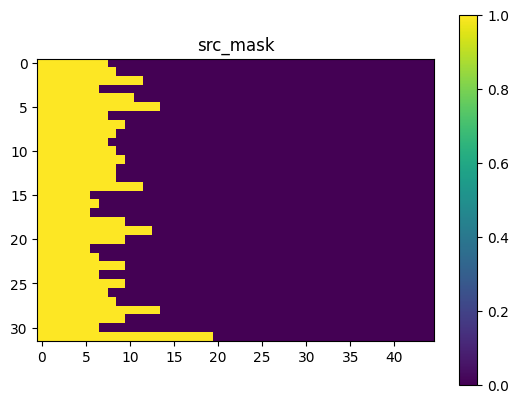

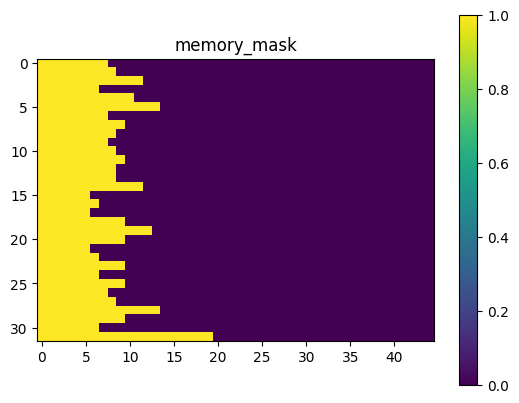

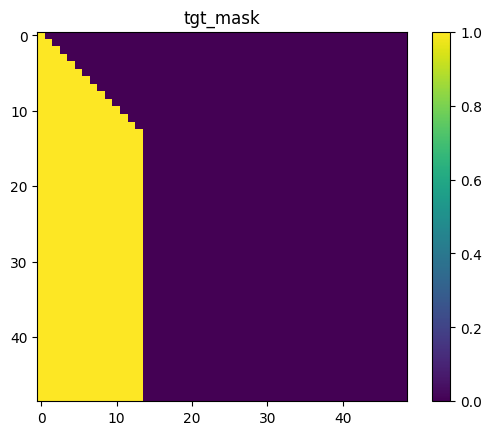

100%|██████████| 904/904 [00:59<00:00, 15.31it/s]


We don' t have any other choice.
我们别无选择。
我们没没法没任
pred_len: 8
Train Loss: 3.4185 | Val Loss: 2.6616 | LR: 0.001000
Epoch: 2/10


100%|██████████| 904/904 [00:54<00:00, 16.63it/s]


I know what you did.
我知道你做了什么。
我知道你做了什么。
pred_len: 10
Train Loss: 2.4469 | Val Loss: 2.2394 | LR: 0.001000
Epoch: 3/10


100%|██████████| 904/904 [00:56<00:00, 15.97it/s]


Is this what you wanted?
这是你要的吗?
这是你想的？？
pred_len: 8
Train Loss: 2.0459 | Val Loss: 2.0801 | LR: 0.001000
Epoch: 4/10


100%|██████████| 904/904 [00:56<00:00, 15.89it/s]


Is this your notebook?
这是你的笔记本吗？
这是你的笔记本笔？
pred_len: 10
Train Loss: 1.6936 | Val Loss: 1.8853 | LR: 0.000800
Epoch: 5/10


100%|██████████| 904/904 [00:55<00:00, 16.43it/s]


Tom has absolutely no enemies.
汤姆绝没有敌人。
汤姆没不有敌人。
pred_len: 9
Train Loss: 1.5005 | Val Loss: 1.8752 | LR: 0.000800
Epoch: 6/10


100%|██████████| 904/904 [00:55<00:00, 16.35it/s]


She always gets lost.
她总是迷路。
她总是迷路。
pred_len: 7
Train Loss: 1.3649 | Val Loss: 1.8005 | LR: 0.000800
Epoch: 7/10


100%|██████████| 904/904 [00:55<00:00, 16.42it/s]


The library is closed on sundays.
图书馆周日不开门。
图书馆周日图到心。
pred_len: 10
Train Loss: 1.1633 | Val Loss: 1.7775 | LR: 0.000640
Epoch: 8/10


100%|██████████| 904/904 [00:56<00:00, 15.86it/s]


It' s my treat.
我请客。
请请把。
pred_len: 5
Train Loss: 1.0592 | Val Loss: 1.7980 | LR: 0.000640
Epoch: 9/10


100%|██████████| 904/904 [00:55<00:00, 16.32it/s]


After supper, she cleared the table.
晚饭后她清理了桌子。
晚饭后她清洗了桌子。
pred_len: 11
Train Loss: 0.9845 | Val Loss: 1.8241 | LR: 0.000640
Epoch: 10/10


100%|██████████| 904/904 [00:55<00:00, 16.31it/s]


He had a second helping of soup.
他又喝了一碗汤。
他喝喝了一杯。。
pred_len: 9
Train Loss: 0.8452 | Val Loss: 1.7817 | LR: 0.000512


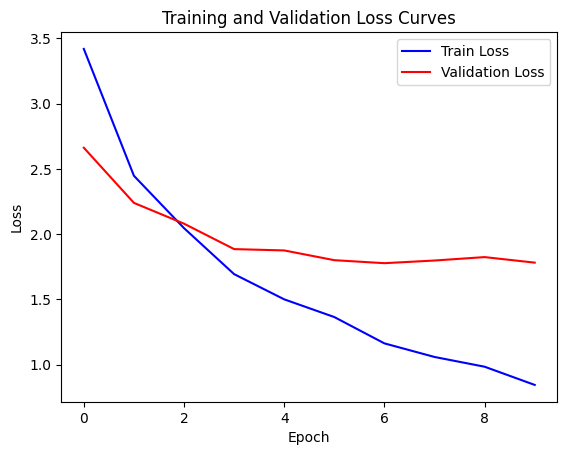

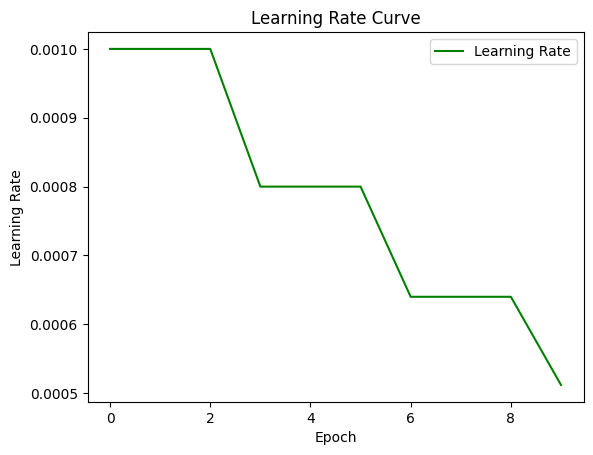

In [16]:
# 定义参数
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer = transformer.to(device)

loss_func = torch.nn.CrossEntropyLoss(ignore_index=2)  # 计算损失时，忽略掉pad_id部分的计算
optimizer = torch.optim.AdamW(transformer.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)  # 每隔固定数量的epoch将学习率减少一个固定的比例

train_loss_curve = []
val_loss_curve = []
lr_curve = []
# 训练和验证
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    transformer.train()
    loss_sum = 0.0

    # 训练----------------------------------------------------
    for step, (src, tgt) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # src: (batch_size, 45)
        # tgt: (batch_size, 50)

        ####################################################
        if step % (len(train_loader)-1) == 0 and step != 0:
            print(id2text(src[0].tolist(), 'en', en_dict_id2token))
            print(id2text(tgt[0].tolist(), 'cn', cn_dict_id2token))
        ####################################################

        # 构造mask
        src_mask = make_src_mask(src=src, pad_id=2)
        memory_mask = make_memory_mask(src=src, pad_id=2)
        tgt_mask = make_tgt_mask(tgt=tgt[:, :-1], pad_id=2)

        ####################################################
        # mask可视化
        if epoch == 0 and step == 0:
            # print(src_mask.shape)
            # print(src_mask)
            # print(memory_mask.shape)
            # print(memory_mask)
            # print(tgt_mask.shape)
            # print(tgt_mask)
            plt.imshow(src_mask.squeeze().numpy(), cmap='viridis', interpolation='nearest')  # (batch_size, seq_len)
            plt.colorbar()
            plt.title('src_mask')
            plt.show()
            plt.imshow(memory_mask.squeeze().numpy(), cmap='viridis', interpolation='nearest')  # (batch_size, seq_len)
            plt.colorbar()
            plt.title('memory_mask')
            plt.show()
            plt.imshow(tgt_mask[0].squeeze().numpy(), cmap='viridis', interpolation='nearest')  # 取了batch中的第一个，(seq_len, seq_len)
            plt.colorbar()
            plt.title('tgt_mask')
            plt.show()
        ####################################################
        
        src = src.to(device).long()
        tgt = tgt.to(device).long()
        src_mask = src_mask.to(device)
        memory_mask = memory_mask.to(device)
        tgt_mask = tgt_mask.to(device)

        # 训练时，是由输入的tgt预测下一个字符，因此输入为tgt[:, :-1]，每一个位置的字符在看见前面已有字符的情况下预测下一个字符
        # 例如，tgt为: <sos> a b c d e <eos> <pad> <pad>，那么输入为：<sos> a b c d e <eos> <pad>，真值为：a b c d e <eos> <pad> <pad>
        # 假设预测输出为：a' b' c' d' e' <eos> <pad> <pad>，该预测输出需要与真实值进行交叉熵计算损失，为避免<pad>对有效token的影响，计算损失时<pad>位置不参与
        # 因此实际需要计算的是：a b c d e <eos> 与 a' b' c' d' e' <eos>的对应字符位置损失
        pred = transformer(src, tgt[:, :-1], src_mask=src_mask, memory_mask=memory_mask, tgt_mask=tgt_mask)

        ####################################################
        # 查看训练时翻译效果
        if step % (len(train_loader)-1) == 0 and step != 0:
            test_pred = pred[0]  # (seq_len, vocab_size)
            test_pred = test_pred.argmax(dim=1)  # (seq_len,)
            test_pred = test_pred.tolist()  # 转换成装了token_id的列表
            if 1 in test_pred:
                eos_index = test_pred.index(1)  # 找到<eos>索引
                test_pred = test_pred[:eos_index+1]
            print(id2text(test_pred, 'cn', cn_dict_id2token))
            print('pred_len:', len(test_pred))
        ####################################################

        # 调整形状以计算损失
        pred = pred.contiguous().view(-1, pred.shape[-1])  # (batch_size, seq_len, cn_vocab_size) -> (batch_size * seq_len, cn_vocab_size)
        target = tgt[:, 1:].contiguous().view(-1)  # (batch_size, seq_len) -> (batch_size * seq_len)
        loss = loss_func(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()  # 当前epoch的累计损失
    
    train_avg_loss = loss_sum / len(train_loader)
    lr = optimizer.param_groups[0]['lr']
    train_loss_curve.append(train_avg_loss)
    lr_curve.append(lr)

    scheduler.step()

    # 验证----------------------------------------------------
    transformer.eval()
    loss_sum = 0.0
    for step, (src, tgt) in enumerate(val_loader):
        # 构造mask
        src_mask = make_src_mask(src=src, pad_id=2)
        memory_mask = make_memory_mask(src=src, pad_id=2)
        tgt_mask = make_tgt_mask(tgt=tgt[:, :-1], pad_id=2)
        
        src = src.to(device).long()
        tgt = tgt.to(device).long()
        src_mask = src_mask.to(device)
        memory_mask = memory_mask.to(device)
        tgt_mask = tgt_mask.to(device)

        pred = transformer(src, tgt[:, :-1], src_mask=src_mask, memory_mask=memory_mask, tgt_mask=tgt_mask)
        pred = pred.contiguous().view(-1, pred.shape[-1])
        target = tgt[:, 1:].contiguous().view(-1)
        loss = loss_func(pred, target)

        loss_sum += loss.item()

    val_avg_loss = loss_sum / len(val_loader)
    val_loss_curve.append(val_avg_loss)
    print(f'Train Loss: {train_avg_loss:.4f} | Val Loss: {val_avg_loss:.4f} | LR: {lr:.6f}')

# 保存模型
torch.save(transformer.state_dict(), 'transformer_from_scratch.pt')

# 绘制损失曲线
plt.figure()
plt.plot(train_loss_curve, label='Train Loss', color='blue')
plt.plot(val_loss_curve, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# 绘制学习率曲线
plt.figure()
plt.plot(lr_curve, label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Curve')
plt.legend()
plt.show()

## （七）预测

In [17]:
# 没有条件训练可以跳过上一个单元格，加载训练好的模型:transformer_from_scratch.pt
# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer.load_state_dict(torch.load('transformer_from_scratch.pt', map_location=device))
transformer = transformer.to(device)

# 构造一个用于预测的函数
def predict(src):
    """
    接收一个源序列，根据源序列，从<sos>开始生成目标序列
    src: (batch_size, src_seq_len)
    """
    transformer.eval()

    # 初始化tgt，从<sos>开始，后面全部填充为<pad>
    batch_size = src.size(0)  # 获取batch_size
    tgt = [cn_dict_token2id['<sos>']] + [cn_dict_token2id['<pad>']] * 48  # 目表序列填充的长度是50，训练时使用49，因此预测时初始化为49
    tgt = torch.LongTensor(tgt).unsqueeze(0)  # (1, tgt_seq_len)
    tgt = tgt.repeat(batch_size, 1)  # (batch_size, tgt_seq_len)

    # 构造mask
    src_mask = make_src_mask(src=src, pad_id=2)
    memory_mask = make_memory_mask(src=src, pad_id=2)

    # 选择设备
    src = src.to(device).long()
    src_mask = src_mask.to(device)
    memory_mask = memory_mask.to(device)

    # 将src的编码器输出存为变量，解码器计算时可以重复使用
    src = transformer.positional_encoding(transformer.src_embedding(src))
    memory = transformer.encoder(src, src_mask=src_mask)

    for i in range(48):  # 逐字符生成
        tgt_temp = tgt  # 赋值给tgt_temp，充当解码器输入，预测的输出更新tgt，而后再返回充当新一轮的解码器输入

        # 构造mask
        tgt_mask = make_tgt_mask(tgt=tgt_temp, pad_id=2)
        tgt_temp = tgt_temp.to(device)
        tgt_mask = tgt_mask.to(device)

        tgt_temp = transformer.positional_encoding(transformer.tgt_embedding(tgt_temp))
        tgt_temp = transformer.decoder(tgt_temp, enc_output=memory, memory_mask=memory_mask, tgt_mask=tgt_mask)
        out = transformer.fc_out(tgt_temp)  # (batch, tgt_seq_len, tgt_vocab_size)

        # 当前预测是第i个词，故取出第i个
        # 第一步输入为：<sos> <pad> <pad> <pad> <pad> <pad> <pad>
        # 第一步预测为：a <pad>' <pad>' <pad>' <pad>' <pad>' <pad>'  (由于<pad>不参与损失计算，预测输出<pad>'实际没有上是没有意义的输出，并非实际的<pad>字符)
        # 取出第一步预测的a，构建第二步输入：<sos> a <pad> <pad> <pad> <pad> <pad>
        # 第二步预测为：a b <pad>' <pad>' <pad>' <pad>' <pad>'，取出第二步预测的b，构建第三步输入：<sos> a b <pad> <pad> <pad> <pad>，直到预测到<eos>结束
        out = out[:, i, :]  # (batch, tgt_seq_len, tgt_vocab_size) -> (batch, tgt_vocab_len)
        # 将预测的logits映射到具体的toekn_id
        out = out.argmax(dim=1).detach()  # 在tgt_vocab_size维度上取最大值，得到预测的token_id -> (batch,)

        # 将本轮预测的词加入到tgt中，用于下一轮预测
        tgt[:, i+1] = out

        # 如果预测的out为<eos>，说明预测结束，返回tgt
        # 本函数仅用于单个字符串预测，因此检查一个序列是否产生<eos>
        # 如果预测多个序列，需要添加逻辑用于跟踪所有序列是否均产生<eos>再退出
        if out == 1:
            return tgt

    # 如果未能预测到<eos>，循环结束直接返回tgt
    return tgt  

In [18]:
# 实测
english_text = 'This is the first part.'

# 将文本转换成token_id
english_token_id = text2id(english_text, 'en', en_dict_token2id)
print('English token id:', english_token_id)

# 预测
src = torch.tensor(english_token_id).unsqueeze(0)  # (1, 45)
predict_token_id = predict(src).squeeze(0).tolist()
print('Predict token id:', predict_token_id)

# 将预测输出的token_id转换成文本
chinese_text = id2text(predict_token_id, 'cn', cn_dict_id2token)
print('Predict chinese text:', chinese_text)

English token id: [0, 134, 184, 479, 176, 1497, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Predict token id: [0, 191, 58, 238, 14, 166, 1241, 254, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Predict chinese text: 这是第一个部分。


# 三、PyTorch封装的Transformer用法

In [19]:
# nn.Transformer没有实现Embedding,PositionalEncoding和最后的Linear, 因此需要自己封装
class TorchTransformer(nn.Module):
    def __init__(self,
                 src_vocab_size, 
                 tgt_vocab_size, 
                 d_model, 
                 nhead, 
                 num_encoder_layers, 
                 num_decoder_layers, 
                 dim_feedforward, 
                 max_seq_length, 
                 dropout=0.1):
        super(TorchTransformer, self).__init__()
        
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, batch_first=True)
        
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src, tgt, src_pad_mask, tgt_pad_mask, tgt_seq_mask):  # tgt的padding mask和sequence mask可以分别传入，模型内会进行合并
        src = self.dropout(self.positional_encoding(self.src_embedding(src)))  # (batch,src_seq_len)->(batch,src_seq_len,d_model)
        tgt = self.dropout(self.positional_encoding(self.tgt_embedding(tgt)))  # (batch,tgt_seq_len)->(batch,tgt_seq_len,d_model)
        # 编码器中的多头注意力使用src_key_padding_mask，传入的是src_pad_mask
        # 解码器中的多头注意力使用tgt_key_padding_mask和tgt_mask，传入的是tgt_pad_mask和tgt_seq_mask，二者会进行合并
        # 解码器中的交叉注意力使用memory_key_padding_mask，传入的是src_pad_mask
        output = self.transformer(src, tgt, tgt_mask=tgt_seq_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask, memory_key_padding_mask=src_pad_mask)
        output = self.fc_out(output)
        return output

# 四、使用PyTorch封装的Transformer模型完成中英翻译demo

## （一）构建模型

In [20]:
# 整体流程与第二部分相同，不同的是传入的mask的部分，mask需要传入bool形式，True表示遮蔽
# 运行此部分代码需要第二部分的（一）至（四）的代码块已经运行过，部分变量已经在内存中

# 构建模型
torch_transformer = TorchTransformer(
    src_vocab_size=en_vocab_size,
    tgt_vocab_size=cn_vocab_size,
    d_model=256,
    nhead=8,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=1024,
    max_seq_length=100,
    dropout=0.1
)

trainable_params = sum(p.numel() for p in torch_transformer.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

import torch.nn.init as init

# nn.Transformer默认的初始化方式是Xavier，在此数据集下，我们定义的学习率调度和迭代次数训练效果并不理想
# 我们这里将初始化方式改为pytorch默认的方式，能够得到较好的效果，这是个有趣的现象
def reset_to_default_init(module):
    if isinstance(module, nn.Linear):
        # PyTorch 默认初始化方式：Kaiming 均匀分布
        init.kaiming_uniform_(module.weight, a=math.sqrt(5))
        if module.bias is not None:
            # PyTorch 默认的偏置初始化
            fan_in, _ = init._calculate_fan_in_and_fan_out(module.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(module.bias, -bound, bound)

torch_transformer.apply(reset_to_default_init)

Total number of trainable parameters: 8828183


TorchTransformer(
  (src_embedding): Embedding(7192, 256)
  (tgt_embedding): Embedding(2839, 256)
  (positional_encoding): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): Tran

## （二）训练

Epoch: 1/10


  0%|          | 0/904 [00:00<?, ?it/s]

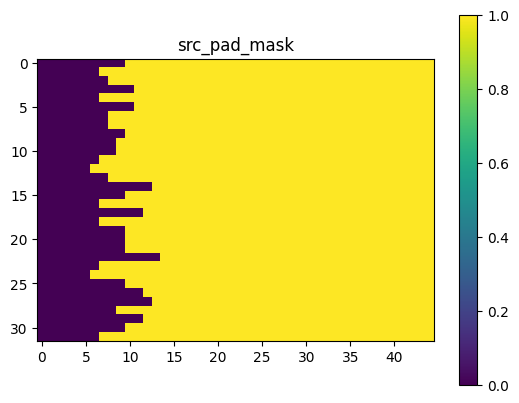

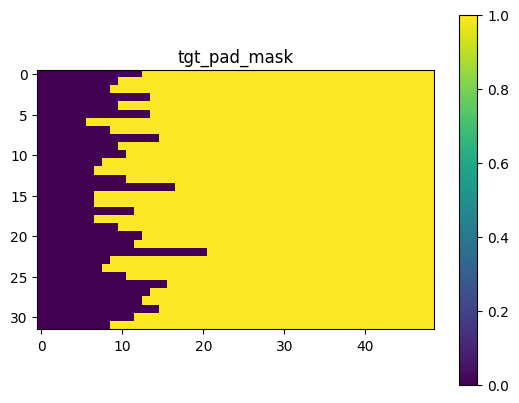

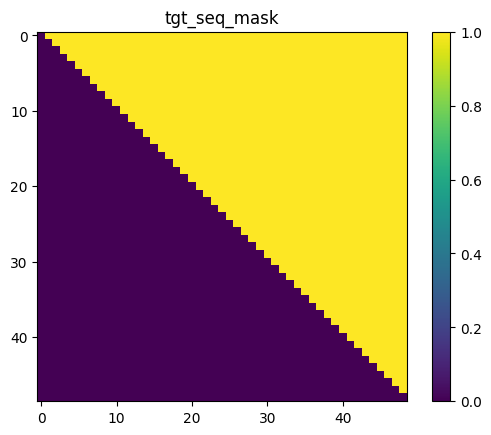

100%|██████████| 904/904 [00:45<00:00, 20.01it/s]


Skating is one of my hobbies.
滑冰是我的嗜好之一。
我他子我的。。人间个
pred_len: 11
Train Loss: 3.4991 | Val Loss: 2.7074 | LR: 0.001000
Epoch: 2/10


100%|██████████| 904/904 [00:42<00:00, 21.25it/s]


Tom doesn' t even talk to mary anymore.
汤姆甚至不和玛丽说话了。
汤姆不么不跟玛丽说话。。
pred_len: 13
Train Loss: 2.5295 | Val Loss: 2.2795 | LR: 0.001000
Epoch: 3/10


100%|██████████| 904/904 [00:44<00:00, 20.22it/s]


They killed time playing cards.
他们玩牌来杀时间。
他们打笑。玩。间玩
pred_len: 10
Train Loss: 2.1220 | Val Loss: 2.1049 | LR: 0.001000
Epoch: 4/10


100%|██████████| 904/904 [00:43<00:00, 20.60it/s]


This is not safe.
这不安全。
这不是全。
pred_len: 6
Train Loss: 1.7576 | Val Loss: 1.9168 | LR: 0.000800
Epoch: 5/10


100%|██████████| 904/904 [00:42<00:00, 21.16it/s]


Do you need help?
你需要帮助吗？
你需要帮忙吗？
pred_len: 8
Train Loss: 1.5634 | Val Loss: 1.8825 | LR: 0.000800
Epoch: 6/10


100%|██████████| 904/904 [00:43<00:00, 20.60it/s]


I asked tom to play the guitar.
我叫汤姆弹吉他。
我请汤姆。吉他。
pred_len: 9
Train Loss: 1.4200 | Val Loss: 1.8326 | LR: 0.000800
Epoch: 7/10


100%|██████████| 904/904 [00:42<00:00, 21.48it/s]


What do you want it for?
您要它干什么？
你要什做什么？
pred_len: 8
Train Loss: 1.2173 | Val Loss: 1.7646 | LR: 0.000640
Epoch: 8/10


100%|██████████| 904/904 [00:44<00:00, 20.22it/s]


I didn' t get the point of his speech.
我没有抓到他演讲的重点。
我没收收到他的讲的演。。
pred_len: 13
Train Loss: 1.1094 | Val Loss: 1.7611 | LR: 0.000640
Epoch: 9/10


100%|██████████| 904/904 [00:42<00:00, 21.12it/s]


This is only one of the things we found.
这只是我们发现的东西之一。
这只是我们找现的一西。一个
pred_len: 14
Train Loss: 1.0284 | Val Loss: 1.7942 | LR: 0.000640
Epoch: 10/10


100%|██████████| 904/904 [00:42<00:00, 21.48it/s]


I looked, but i didn' t see anything.
我看过了, 但是没看到什么东西。
我什了，， 但什没看到看么。西。
pred_len: 17
Train Loss: 0.8901 | Val Loss: 1.7749 | LR: 0.000512


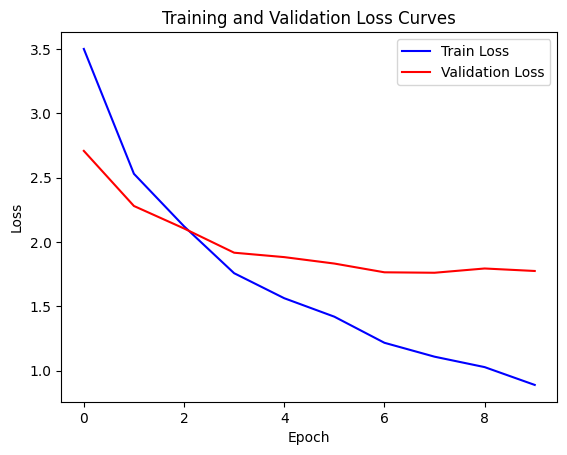

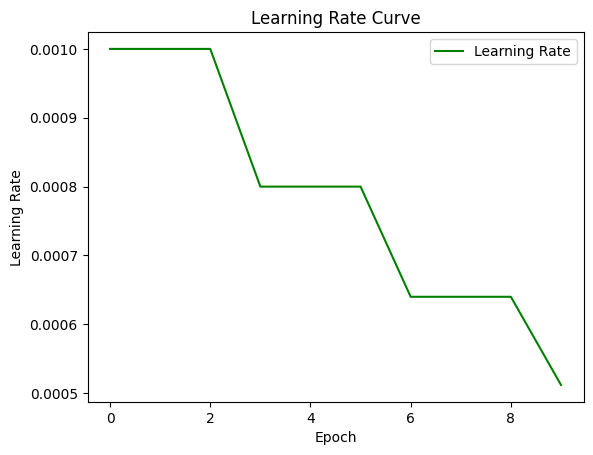

In [21]:
# 定义参数
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch_transformer = torch_transformer.to(device)

loss_func = torch.nn.CrossEntropyLoss(ignore_index=2)  # 计算损失时，忽略掉pad_id部分的计算
optimizer = torch.optim.AdamW(torch_transformer.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)  # 每隔固定数量的epoch将学习率减少一个固定的比例

train_loss_curve = []
val_loss_curve = []
lr_curve = []
# 训练和验证
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    torch_transformer.train()
    loss_sum = 0.0

    # 训练----------------------------------------------------
    for step, (src, tgt) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # src: (batch_size, 45)
        # tgt: (batch_size, 50)

        ####################################################
        if step % (len(train_loader)-1) == 0 and step != 0:
            print(id2text(src[0].tolist(), 'en', en_dict_id2token))
            print(id2text(tgt[0].tolist(), 'cn', cn_dict_id2token))
        ####################################################

        # 构造mask 【此处构造适合nn.Transformer的mask】
        src_pad_mask = make_padding_mask(src, pad_id=2, return_int=False, true_to_mask=True)  # (batch_size, seq_len)
        tgt_pad_mask = make_padding_mask(tgt[:, :-1], pad_id=2, return_int=False, true_to_mask=True)  # (batch_size, seq_len)
        tgt_seq_mask = make_sequence_mask(tgt[:, :-1], return_int=False, true_to_mask=True)  # 需传入(T, T)或(N*num_heads, T, T)的形状，这里我们就传入(T, T)，即(seq_len, seq_len)

        ####################################################
        if epoch == 0 and step == 0:
            # print(src_pad_mask.shape)
            # print(src_pad_mask)
            # print(tgt_pad_mask.shape)
            # print(tgt_pad_mask)
            # print(tgt_seq_mask.shape)
            # print(tgt_seq_mask)
            plt.imshow(src_pad_mask.numpy(), cmap='viridis', interpolation='nearest')
            plt.colorbar()  # 添加颜色条
            plt.title('src_pad_mask')
            plt.show()
            plt.imshow(tgt_pad_mask.numpy(), cmap='viridis', interpolation='nearest')
            plt.colorbar()  # 添加颜色条
            plt.title('tgt_pad_mask')
            plt.show()
            plt.imshow(tgt_seq_mask.numpy(), cmap='viridis', interpolation='nearest')
            plt.colorbar()  # 添加颜色条
            plt.title('tgt_seq_mask')
            plt.show()
        ####################################################
        
        src = src.to(device).long()
        tgt = tgt.to(device).long()
        src_pad_mask = src_pad_mask.to(device)
        tgt_pad_mask = tgt_pad_mask.to(device)
        tgt_seq_mask = tgt_seq_mask.to(device)

        # 训练时，是由输入的tgt预测下一个字符，因此输入为tgt[:, :-1]，每一个位置的字符在看见前面已有字符的情况下预测下一个字符
        # 例如，tgt为: <sos> a b c d e <eos> <pad> <pad>，那么输入为：<sos> a b c d e <eos> <pad>，真值为：a b c d e <eos> <pad> <pad>
        # 假设预测输出为：a' b' c' d' e' <eos> <pad> <pad>，该预测输出需要与真实值进行交叉熵计算损失，为避免<pad>对有效token的影响，计算损失时<pad>位置不参与
        # 因此实际需要计算的是：a b c d e <eos> 与 a' b' c' d' e' <eos>的对应字符位置损失
        pred = torch_transformer(src, tgt[:, :-1], src_pad_mask, tgt_pad_mask, tgt_seq_mask)

        ####################################################
        if step % (len(train_loader)-1) == 0 and step != 0:
            test_pred = pred[0]  # (seq_len, vocab_size)
            test_pred = test_pred.argmax(dim=1)  # (seq_len,)
            test_pred = test_pred.tolist()  # 转换成装了token_id的列表
            if 1 in test_pred:
                eos_index = test_pred.index(1)  # 找到<eos>索引
                test_pred = test_pred[:eos_index+1]
            print(id2text(test_pred, 'cn', cn_dict_id2token))
            print('pred_len:', len(test_pred))
        ####################################################

        # 调整形状以计算损失
        pred = pred.contiguous().view(-1, pred.shape[-1])  # (batch_size, seq_len, cn_vocab_size) -> (batch_size * seq_len, cn_vocab_size)
        target = tgt[:, 1:].contiguous().view(-1)  # (batch_size, seq_len) -> (batch_size * seq_len)
        loss = loss_func(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()  # 当前epoch的累计损失
    
    train_avg_loss = loss_sum / len(train_loader)
    lr = optimizer.param_groups[0]['lr']
    train_loss_curve.append(train_avg_loss)
    lr_curve.append(lr)

    scheduler.step()

    # 验证----------------------------------------------------
    torch_transformer.eval()
    loss_sum = 0.0
    for step, (src, tgt) in enumerate(val_loader):
        # 构造mask 【此处构造适合nn.Transformer的mask】
        src_pad_mask = make_padding_mask(src, pad_id=2, return_int=False, true_to_mask=True)  # (batch_size, seq_len)
        tgt_pad_mask = make_padding_mask(tgt[:, :-1], pad_id=2, return_int=False, true_to_mask=True)  # (batch_size, seq_len)
        tgt_seq_mask = make_sequence_mask(tgt[:, :-1], return_int=False, true_to_mask=True)  # 需传入(T, T)或(N*num_heads, T, T)的形状，这里我们就传入(T, T)，即(seq_len, seq_len)
        
        src = src.to(device).long()
        tgt = tgt.to(device).long()
        src_pad_mask = src_pad_mask.to(device)
        tgt_pad_mask = tgt_pad_mask.to(device)
        tgt_seq_mask = tgt_seq_mask.to(device)

        pred = torch_transformer(src, tgt[:, :-1], src_pad_mask, tgt_pad_mask, tgt_seq_mask)
        pred = pred.contiguous().view(-1, pred.shape[-1])
        target = tgt[:, 1:].contiguous().view(-1)
        loss = loss_func(pred, target)

        loss_sum += loss.item()

    val_avg_loss = loss_sum / len(val_loader)
    val_loss_curve.append(val_avg_loss)
    print(f'Train Loss: {train_avg_loss:.4f} | Val Loss: {val_avg_loss:.4f} | LR: {lr:.6f}')

# 保存模型
torch.save(torch_transformer.state_dict(), 'transformer_from_torch.pt')

# 绘制损失曲线
plt.figure()
plt.plot(train_loss_curve, label='Train Loss', color='blue')
plt.plot(val_loss_curve, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# 绘制学习率曲线
plt.figure()
plt.plot(lr_curve, label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Curve')
plt.legend()
plt.show()

## （三）预测

In [22]:
# 没有条件训练可以跳过上一个单元格，加载训练好的模型:transformer_from_scratch.pt
# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch_transformer.load_state_dict(torch.load('transformer_from_torch.pt', map_location=device))
torch_transformer = torch_transformer.to(device)

# 构造一个用于预测的函数
def predict_torch(src):
    """
    接收一个源序列，根据源序列，从<sos>开始生成目标序列
    src: (batch_size, src_seq_len)
    """
    torch_transformer.eval()

    # 初始化tgt，从<sos>开始，后面全部填充为<pad>
    batch_size = src.size(0)  # 获取batch_size
    tgt = [cn_dict_token2id['<sos>']] + [cn_dict_token2id['<pad>']] * 48  # 目表序列填充的长度是50，训练时使用49，因此预测时初始化为49
    tgt = torch.LongTensor(tgt).unsqueeze(0)  # (1, tgt_seq_len)
    tgt = tgt.repeat(batch_size, 1)  # (batch_size, tgt_seq_len)

    # 构造mask 【这里只构造src_pad_mask，也就是第二部分的src_mask，实际上src_mask和memory_mask是构造时是相同的，只是内部实现时广播后的维度有区别】
    src_pad_mask = make_padding_mask(src, pad_id=2, return_int=False, true_to_mask=True)

    # 选择设备
    src = src.to(device).long()
    src_pad_mask = src_pad_mask.to(device)

    # 将src的编码器输出存为变量，解码器计算时可以重复使用
    src = torch_transformer.positional_encoding(torch_transformer.src_embedding(src))
    # 【这里需使用nn.Transformer类内定义的encoder，后面有涉及到的也是一样，传入参数需参考官方文档，这里我们只用为关键字src和src_key_padding_mask传入值】
    memory = torch_transformer.transformer.encoder(src=src, src_key_padding_mask=src_pad_mask)

    for i in range(48):  # 逐字符生成
        tgt_temp = tgt  # 赋值给tgt_temp，充当解码器输入，预测的输出更新tgt，而后再返回充当新一轮的解码器输入

        # 构造mask 【这里构造tgt的mask，分别为tgt_pad_mask和tgt_seq_mask，二者会在模型内部合并。在第二部分中，我们是在模型外通过定义函数合并的】
        tgt_pad_mask = make_padding_mask(tgt_temp, pad_id=2, return_int=False, true_to_mask=True)
        tgt_seq_mask = make_sequence_mask(tgt_temp, return_int=False, true_to_mask=True)
        tgt_temp = tgt_temp.to(device)
        tgt_pad_mask = tgt_pad_mask.to(device)
        tgt_seq_mask = tgt_seq_mask.to(device)

        tgt_temp = torch_transformer.positional_encoding(torch_transformer.tgt_embedding(tgt_temp))
        tgt_temp = torch_transformer.transformer.decoder(tgt=tgt_temp, memory=memory, tgt_mask=tgt_seq_mask, tgt_key_padding_mask=tgt_pad_mask, memory_key_padding_mask=src_pad_mask)
        out = torch_transformer.fc_out(tgt_temp)  # (batch, tgt_seq_len, tgt_vocab_size)

        # 当前预测是第i个词，故取出第i个
        # 第一步输入为：<sos> <pad> <pad> <pad> <pad> <pad> <pad>
        # 第一步预测为：a <pad>' <pad>' <pad>' <pad>' <pad>' <pad>'  (由于<pad>不参与损失计算，预测输出<pad>'实际没有上是没有意义的输出，并非实际的<pad>字符)
        # 取出第一步预测的a，构建第二步输入：<sos> a <pad> <pad> <pad> <pad> <pad>
        # 第二步预测为：a b <pad>' <pad>' <pad>' <pad>' <pad>'，取出第二步预测的b，构建第三步输入：<sos> a b <pad> <pad> <pad> <pad>，直到预测到<eos>结束
        out = out[:, i, :]  # (batch, tgt_seq_len, tgt_vocab_size) -> (batch, tgt_vocab_len)
        # 将预测的logits映射到具体的toekn_id
        out = out.argmax(dim=1).detach()  # 在tgt_vocab_size维度上取最大值，得到预测的token_id -> (batch,)

        # 将本轮预测的词加入到tgt中，用于下一轮预测
        tgt[:, i+1] = out

        # 如果预测的out为<eos>，说明预测结束，返回tgt
        # 本函数仅用于单个字符串预测，因此检查一个序列是否产生<eos>
        # 如果预测多个序列，需要添加逻辑用于跟踪所有序列是否均产生<eos>再退出
        if out == 1:
            return tgt

    # 如果未能预测到<eos>，循环结束直接返回tgt
    return tgt

In [23]:
# 实测
english_text = 'This is the last part.'

# 将文本转换成token_id
english_token_id = text2id(english_text, 'en', en_dict_token2id)
print('English token id:', english_token_id)

# 预测
src = torch.tensor(english_token_id).unsqueeze(0)  # (1, 45)
predict_token_id = predict_torch(src).squeeze(0).tolist()
print('Predict token id:', predict_token_id)

# 将预测输出的token_id转换成文本
chinese_text = id2text(predict_token_id, 'cn', cn_dict_id2token)
print('Predict chinese text:', chinese_text)

English token id: [0, 134, 184, 479, 1105, 1497, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Predict token id: [0, 191, 58, 579, 1043, 9, 1241, 254, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Predict chinese text: 这是最终的部分。
